# Requirements

In [1]:
!pip install gamspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 6.5 MB/s eta 0:00:00


In [2]:
# from gamspy import Set,Container,Variable, Sum, Equation, Model,Problem,Sense,Options
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Data Preprocessing

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/dudegladiator/Logistic-optimization-for-industrial-expansion/main/data/Preprocessed_Russia_Cities_Database.csv")
df

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper,cost,usable
0,Moscow,55.7558,37.6172,Russia,RU,Moskva,primary,17332000,1733200000,6000,0
1,Khabarovsk,48.4833,135.0833,Russia,RU,Khabarovskiy Kray,admin,616242,616242,3140,0
2,Volgograd,48.7086,44.5147,Russia,RU,Volgogradskaya Oblast’,admin,1004763,1004763,2160,0
3,Saratov,51.5333,46.0167,Russia,RU,Saratovskaya Oblast’,admin,845300,845300,2070,0
4,Ulyanovsk,54.3167,48.3667,Russia,RU,Ul’yanovskaya Oblast’,admin,624518,624518,2080,0
...,...,...,...,...,...,...,...,...,...,...,...
145,Novokuybyshevsk,53.1000,49.9333,Russia,RU,Samarskaya Oblast’,NaN,102075,102075,2000,0
146,Zheleznogorsk,52.3333,35.3667,Russia,RU,Kurskaya Oblast’,minor,100740,100740,2000,0
147,Zelënodol’sk,55.8500,48.5167,Russia,RU,Tatarstan,NaN,100009,100009,2000,0
148,Gatchina,59.5833,30.1333,Russia,RU,Leningradskaya Oblast’,admin,94447,94447,2000,0


In [4]:
#Data
total = 150 # No. of cities, we are taking
rang = 400 # Range of distance
var_cost = 12 # Cost of each vKM
fix_cost = 75 # Base Price
capacity = 5 # Capacity of the Truck

cit = df['city'][:total].to_list()
x_cor = df['lat'][:total].to_list()
y_cor = df['lng'][:total].to_list()
population = df['population'][:total].to_list()
cost = df['cost'][:total].to_list()

In [5]:
usable = []
for i in range(total):
    if(i<120):
        usable.append(1)
    else:
        usable.append(0)

Finding the distance

In [6]:
import geopy.distance
dist = [[0 for i in range(total)] for j in range(total)]
for i in range(total):
    for j in range(total):
        dist[i][j] = geopy.distance.geodesic((x_cor[i], y_cor[i]), (x_cor[j], y_cor[j])).km

#Visualization

Plotting the city data

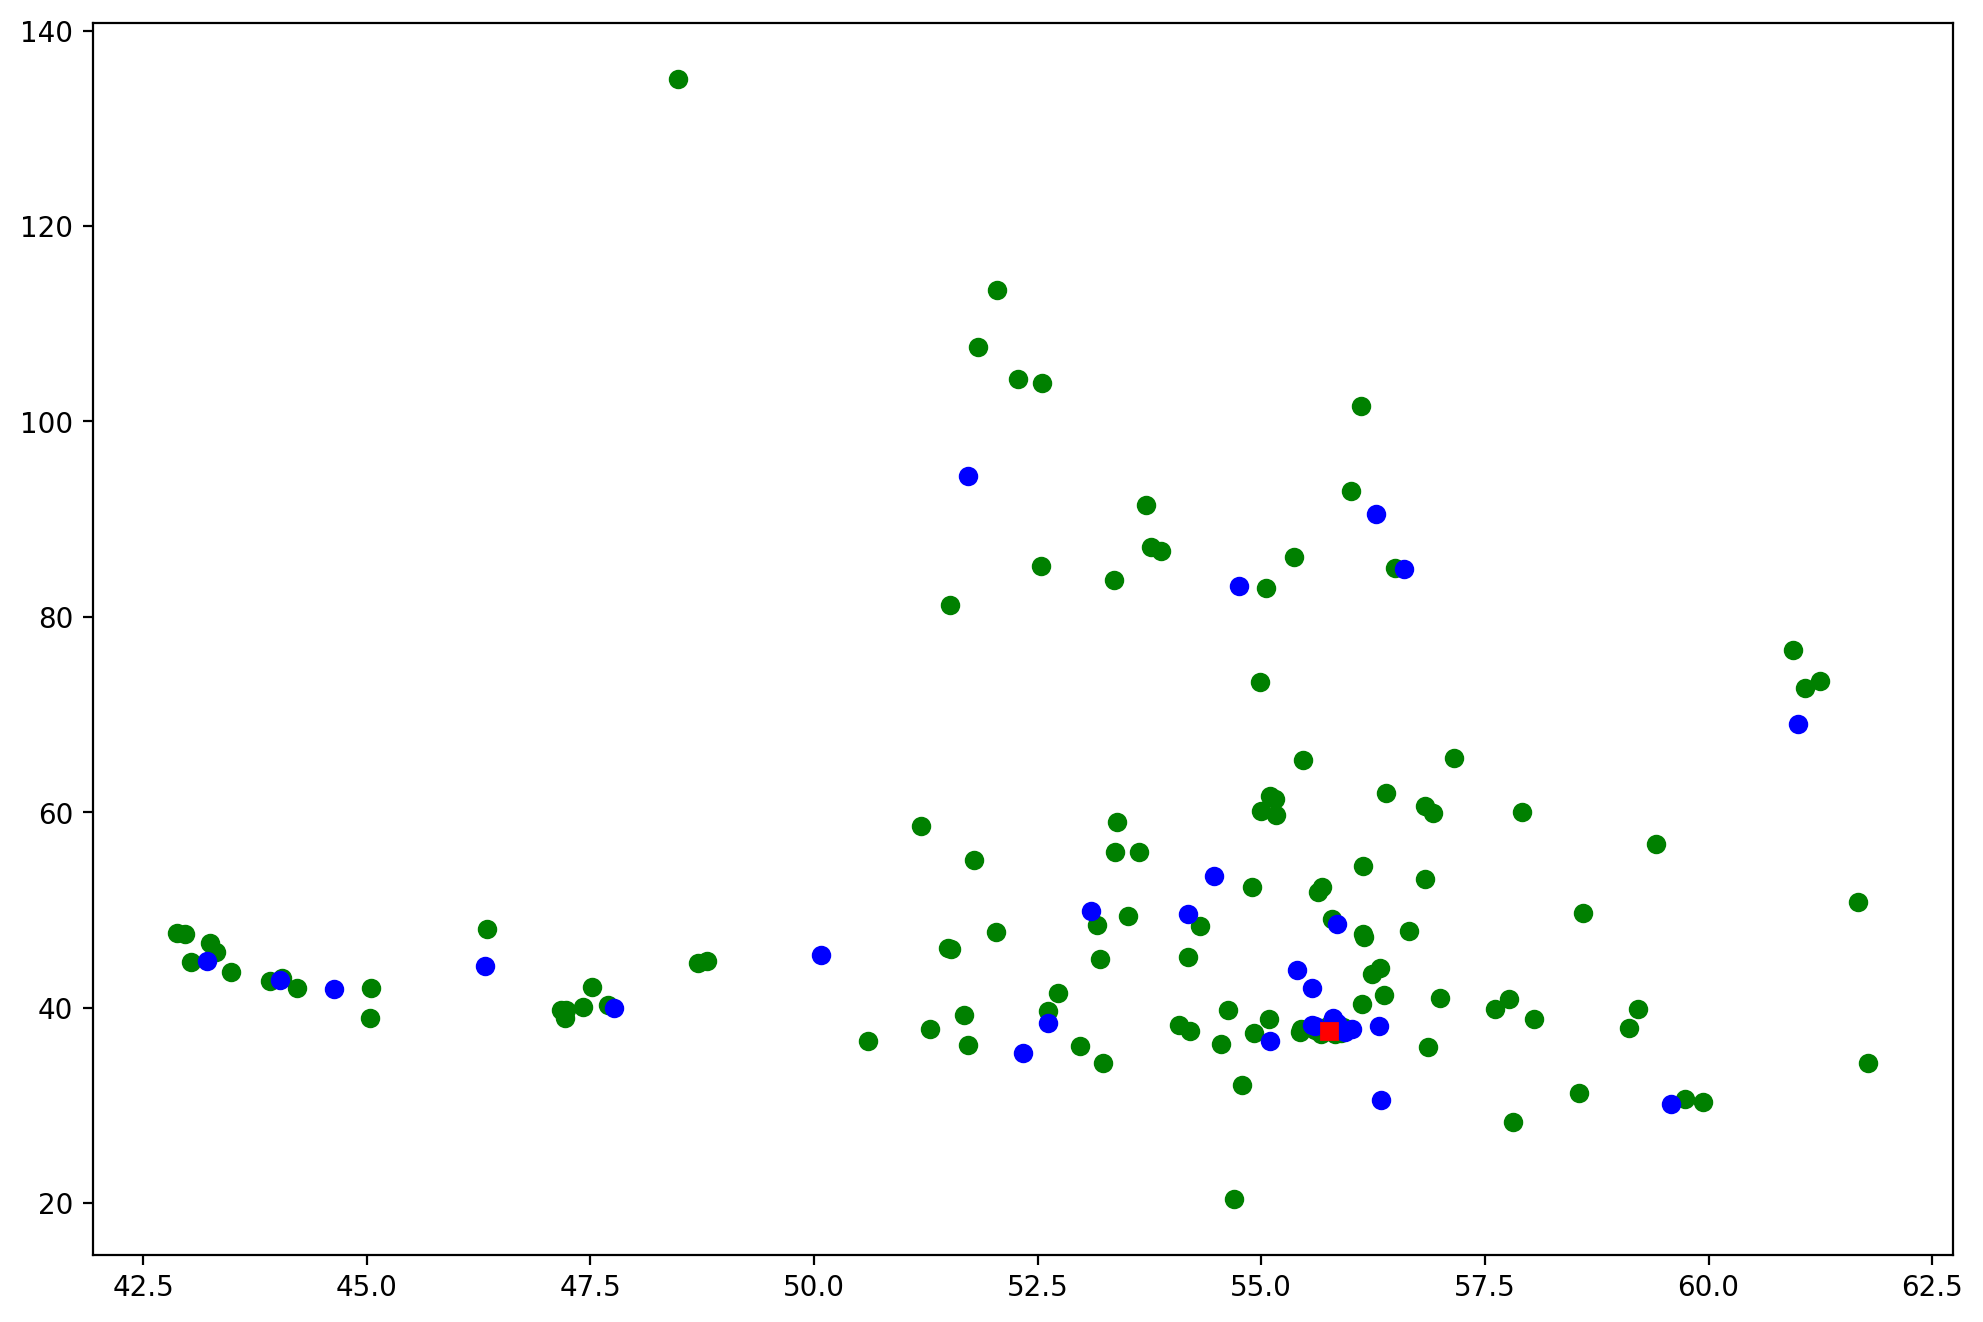

In [7]:
# Plot the region
fig = plt.figure()
fig.set_size_inches(12,8)
fig.set_dpi(200)
plot = fig.add_subplot()
plot.plot(x_cor[0], y_cor[0], c='r',marker='s') #depot

usableCX = dict()
usableCY = dict()
nonUsableCX = dict()
nonUsableCY = dict()
total = len(x_cor)
for i in range(total):
    if usable[i]==1:
        usableCX.update({i: x_cor[i]})
        usableCY.update({i: y_cor[i]})
    else:
        nonUsableCX.update({i: x_cor[i]})
        nonUsableCY.update({i: y_cor[i]})

plot.scatter(list(usableCX.values()), list(usableCY.values()), c='g')
plot.scatter(list(nonUsableCX.values()), list(nonUsableCY.values()) , c='b')

In [8]:
# Initialize variables to store sum and count
total_sum = 0
total_count = 0

# Iterate over each row in the 2D list
for row in dist:
    # Iterate over each element in the row
    for element in row:
        # Add the element to the total sum
        total_sum += element
        # Increment the count of elements
        total_count += 1

# Calculate the average
if total_count > 0:
    average = total_sum / total_count
    print("Average of dist elements:", average)
else:
    print("The dist list is empty.")

Average of dist elements: 1508.1703076356687


In [9]:
len(cit), len(x_cor), len(y_cor), len(population), len(usable), len(cost)

(150, 150, 150, 150, 150, 150)

#Assignment Optimization

In [10]:
from gamspy import *

In [11]:
cont = Container()

In [12]:
city = Set(
    container=cont,
    name='city',
    records=cit
)
city.records

,uni,element_text
0,Moscow,
1,Khabarovsk,
2,Volgograd,
3,Saratov,
4,Ulyanovsk,
...,...,...
145,Novokuybyshevsk,
146,Zheleznogorsk,
147,Zelënodol’sk,
148,Gatchina,


In [13]:
x=Variable(
    container=cont,
    name='x',
    domain = city,
    type='binary',
    description='exist or not'
)

In [14]:
for i,j in enumerate(cit):
    if(usable[i]==0):
        Equation(container=cont,name=f'c{i}')[...] = x[j]==0
    Equation(container=cont,name=f'co{i}')[...] = sum(x[q] for p,q in enumerate(cit) if dist[i][p]<=rang) >= 1

Equation(container=cont,name='alwys')[...] = x[cit[0]] == 1

In [15]:
obj=Variable(
    container=cont,
    name='obj'
)

In [16]:
obj = sum(x[j]*cost[i] for i,j in enumerate(cit))

In [17]:
optimal=Model(
    container=cont,
    name='optimal',
    equations=cont.getEquations(),
    problem=Problem.MIP,
    sense=Sense.MIN,
    objective=obj)

In [18]:
optimal.solve(output=sys.stdout,options=Options(solver='CPLEX',iteration_limit=10000,job_time_limit=1000,time_limit=1000))

--- Job _job_fd497544-d0da-4f0f-86f0-0b1cf9fa0152.gms Start 04/09/24 07:40:08 46.4.0 2cbe6e3b LEX-LEG x86 64bit/Linux
--- Applying:
    /usr/local/lib/python3.10/dist-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    LP CPLEX
    MIP CPLEX
    RMIP CPLEX
    NLP CONOPT
    MCP PATH
    MPEC NLPEC
    RMPEC CONVERT
    CNS CONOPT
    DNLP CONOPT
    RMINLP CONOPT
    MINLP SBB
    QCP CONOPT
    MIQCP SBB
    RMIQCP CONOPT
    EMP CONVERT
    Restart /tmp/tmp7n1tho37/_save_53b8a7fd-e454-4ba9-8582-b9d9e4170ce4.g00
    Input /tmp/tmp7n1tho37/_job_fd497544-d0da-4f0f-86f0-0b1cf9fa0152.gms
    Output /tmp/tmp7n1tho37/_job_fd497544-d0da-4f0f-86f0-0b1cf9fa0152.lst
    Save /tmp/tmp7n1tho37/_restart_53b8a7fd-e454-4ba9-8582-b9d9e4170ce4.g00
    ScrDir /tmp/tmp7n1tho37/225a/
    SysDir /usr/local/lib/python3.10/dist-packages/gamspy_base/
    CurDir /tmp/tmp7n1tho37/
    LogOption 3
    LogFile /tmp/tmp7n1tho37/_job_fd497544-d0da-4f0f-86f0-0b1cf9fa0152.log
    Trace /tmp/tmp7n1tho3

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,43170,182,151,MIP,CPLEX,0.067


In [19]:
x.records

,city,level,marginal,lower,upper,scale
0,Moscow,1.0,6000.0,0.0,1.0,1.0
1,Khabarovsk,1.0,3140.0,0.0,1.0,1.0
2,Volgograd,0.0,2160.0,0.0,1.0,1.0
3,Saratov,0.0,2070.0,0.0,1.0,1.0
4,Ulyanovsk,0.0,2080.0,0.0,1.0,1.0
...,...,...,...,...,...,...
145,Novokuybyshevsk,0.0,2000.0,0.0,1.0,1.0
146,Zheleznogorsk,0.0,2000.0,0.0,1.0,1.0
147,Zelënodol’sk,0.0,2000.0,0.0,1.0,1.0
148,Gatchina,0.0,2000.0,0.0,1.0,1.0


In [20]:
buildingCosts = optimal.objective_value * 1000
buildingCosts

43170000.0

In [21]:
storesCoords = {}
for i,j in enumerate(x.records['level']):
    if(j==1):
        storesCoords[i] = (x_cor[i],y_cor[i])

storesCoords.keys()

dict_keys([0, 1, 14, 16, 32, 33, 47, 52, 53, 61, 73, 77, 78, 82, 88, 91, 105, 109, 118])

# Graphical Analysis

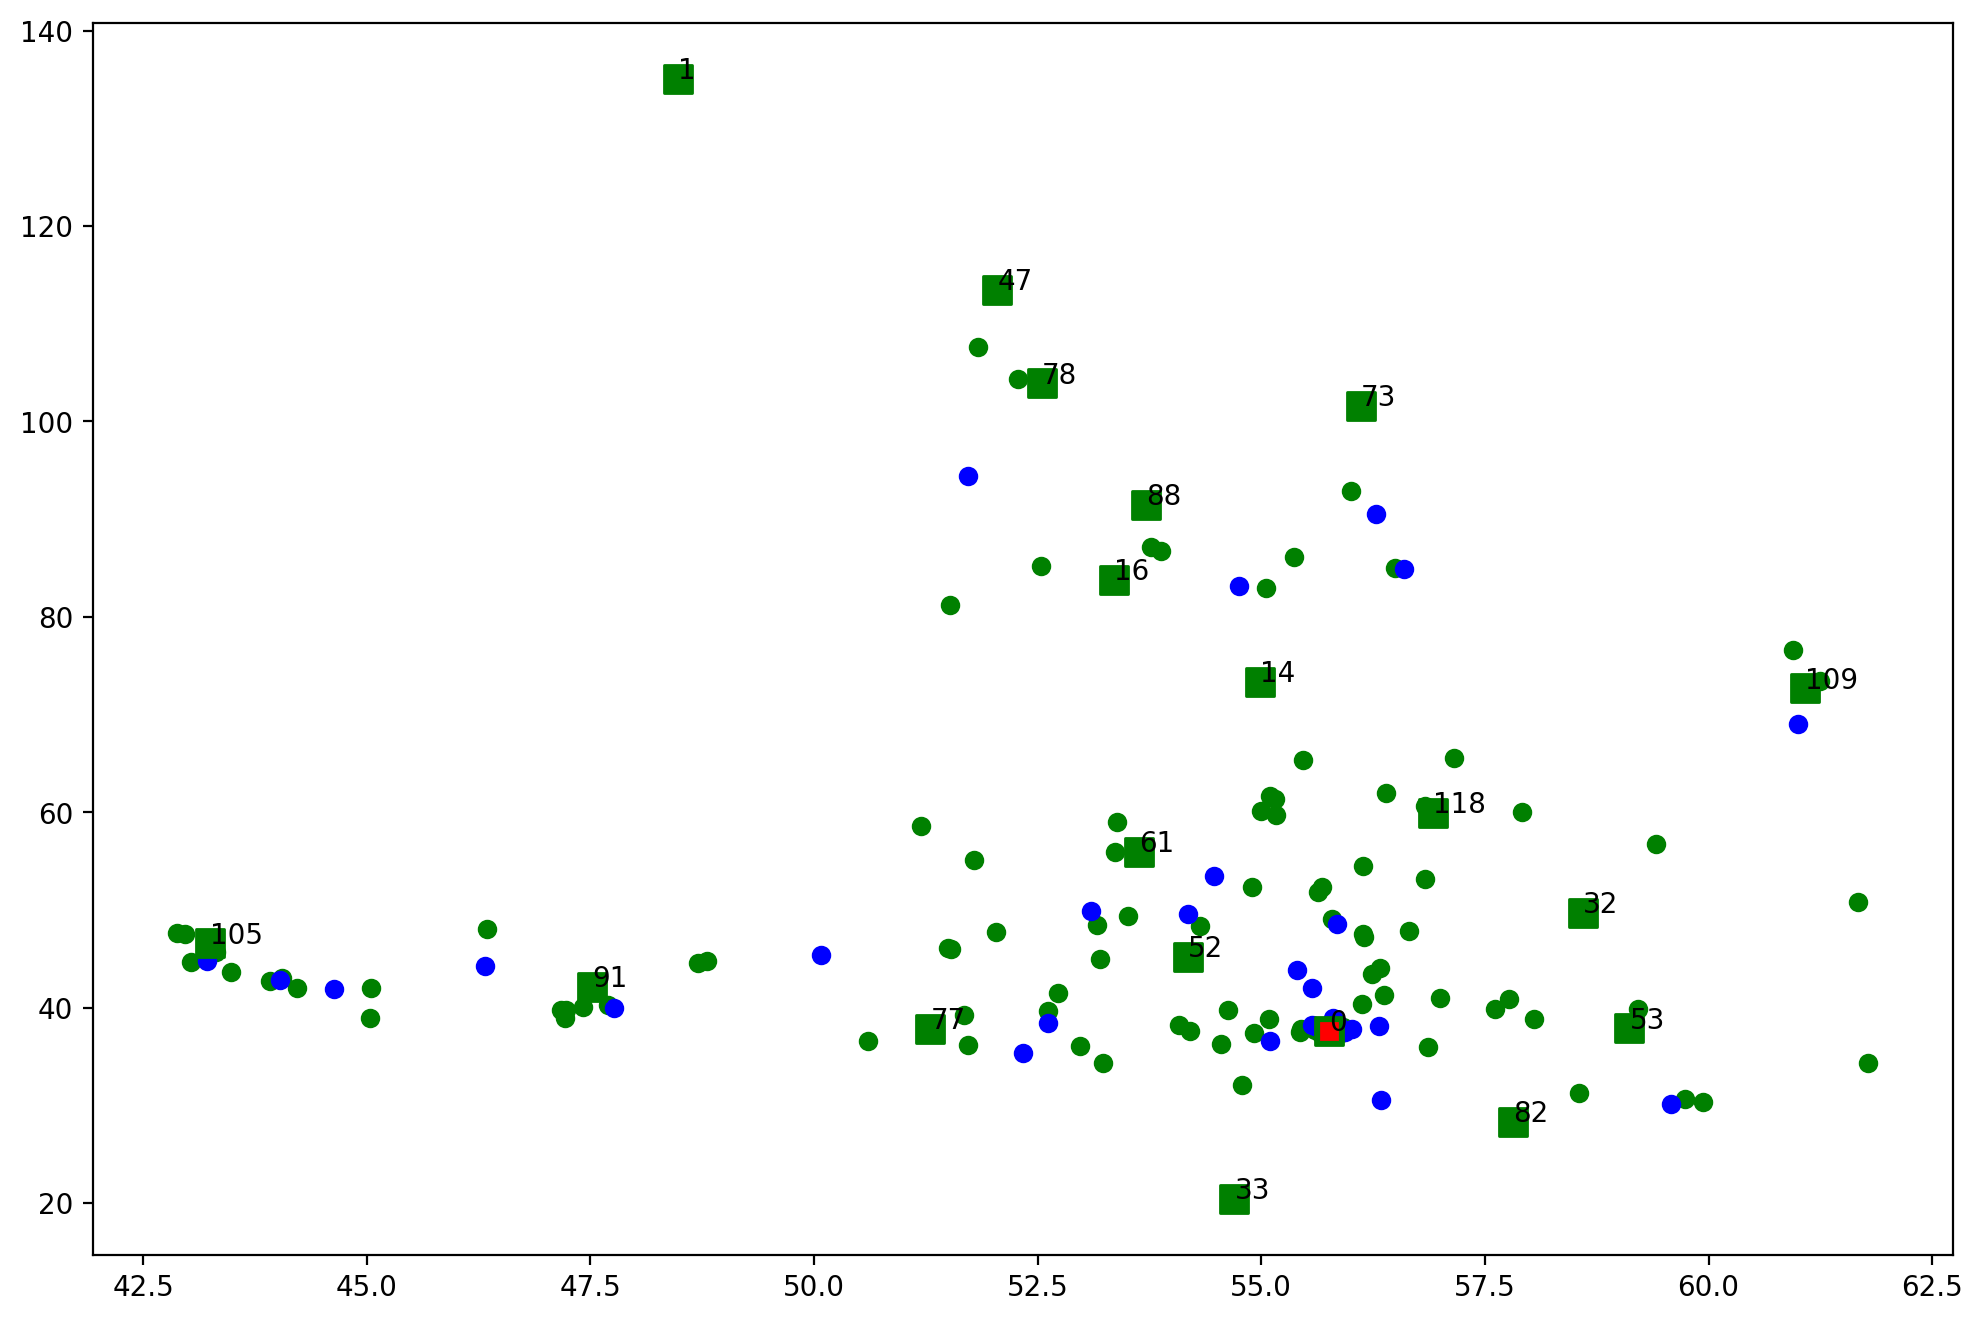

In [22]:
plot.scatter([c[0] for c in storesCoords.values()], [c[1] for c in storesCoords.values()], c='g', marker='s', s=100)
for c in storesCoords:
    plot.add_artist(plt.Circle(storesCoords.get(c), rang, color='g', fill=False, linewidth=0.1))
    plot.annotate(c, storesCoords.get(c))
fig

# Clark Wright Savings Algorithm

In [23]:
def calculate_distance_savings():
    stores_indices = storesCoords.keys()
    distance_savings = [(dist[0][i] + dist[0][j] - dist[i][j], i+1, j+1) for i in stores_indices for j in stores_indices if i != j and i > j]
    distance_savings.sort(reverse=True)
    return distance_savings

In [24]:
distance_savings = calculate_distance_savings()
routes = [[1,i+1,1] for i in storesCoords.keys() if i>0]

In [25]:
def find_routes_passing_through(location1, location2):
    route1 = None
    route2 = None
    for route in routes:
        if route1 is not None and route2 is not None:
            break
        if route[1] == location1:
            route.reverse()
            route1 = route
            continue
        elif route[-2] == location1:
            route1 = route
            continue
        if route[1] == location2:
            route2 = route
            continue
        elif route[-2] == location2:
            route.reverse()
            route2 = route
            continue
    return route1, route2


In [26]:
def merge_routes(route1, intermediate_locations, route2):
    route1_copy = list(route1)
    route2_copy = list(route2)
    del route1_copy[-2:]
    del route2_copy[:2]
    return route1_copy + intermediate_locations + route2_copy

def clarke_wright():
    while len(distance_savings) > 0:
        current_saving = distance_savings.pop(0)
        r1, r2 = find_routes_passing_through(current_saving[1], current_saving[2])
        if r1 is not None and r2 is not None:
            new_route = merge_routes(r1, [current_saving[1], current_saving[2]], r2)
            if len(new_route) - 2 <= capacity:  # excluding the store at location 1 (depot)
                routes.remove(r1)
                routes.remove(r2)
                routes.insert(0, new_route)

In [27]:
clarke_wright()

# Solution

In [28]:
colors = iter(cm.rainbow(np.linspace(0, 1, len(routes))))
for route in routes:
    color = next(colors)
    for i, j in zip(route, route[1:]):
        print(i, j)
        x_val = [storesCoords[i-1][0], storesCoords[j-1][0]]
        y_val = [storesCoords[i-1][1], storesCoords[j-1][1]]
        print(x_val, y_val)
        plot.plot(x_val, y_val, lw=1, color=color)

1 54
[55.7558, 59.1167] [37.6172, 37.9]
54 83
[59.1167, 57.8167] [37.9, 28.3333]
83 34
[57.8167, 54.7003] [28.3333, 20.4531]
34 1
[54.7003, 55.7558] [20.4531, 37.6172]
1 78
[55.7558, 51.3] [37.6172, 37.8333]
78 92
[51.3, 47.5167] [37.8333, 42.15]
92 106
[47.5167, 43.25] [42.15, 46.5833]
106 53
[43.25, 54.1833] [46.5833, 45.1833]
53 33
[54.1833, 58.6] [45.1833, 49.6833]
33 1
[58.6, 55.7558] [49.6833, 37.6172]
1 110
[55.7558, 61.0833] [37.6172, 72.7]
110 17
[61.0833, 53.3486] [72.7, 83.7764]
17 15
[53.3486, 54.9833] [83.7764, 73.3667]
15 119
[54.9833, 56.9167] [73.3667, 59.9333]
119 62
[56.9167, 53.6333] [59.9333, 55.95]
62 1
[53.6333, 55.7558] [55.95, 37.6172]
1 89
[55.7558, 53.7167] [37.6172, 91.4667]
89 74
[53.7167, 56.1167] [91.4667, 101.6]
74 79
[56.1167, 52.55] [101.6, 103.9]
79 48
[52.55, 52.05] [103.9, 113.4667]
48 2
[52.05, 48.4833] [113.4667, 135.0833]
2 1
[48.4833, 55.7558] [135.0833, 37.6172]


In [29]:
totalKm = 0
for route in routes:
    for i, j in zip(route, route[1:]):
        totalKm = totalKm + dist[i-1][j-1]
        #print((i,j))
drivingCosts = totalKm * var_cost
drivingFees = len(routes) * fix_cost
totalRefCosts = drivingCosts + drivingFees + buildingCosts
print("driving Costs: ", drivingCosts + drivingFees)
print("total Costs:", totalRefCosts)

driving Costs:  314119.62645695434
total Costs: 43484119.62645695


# Visualizing the route

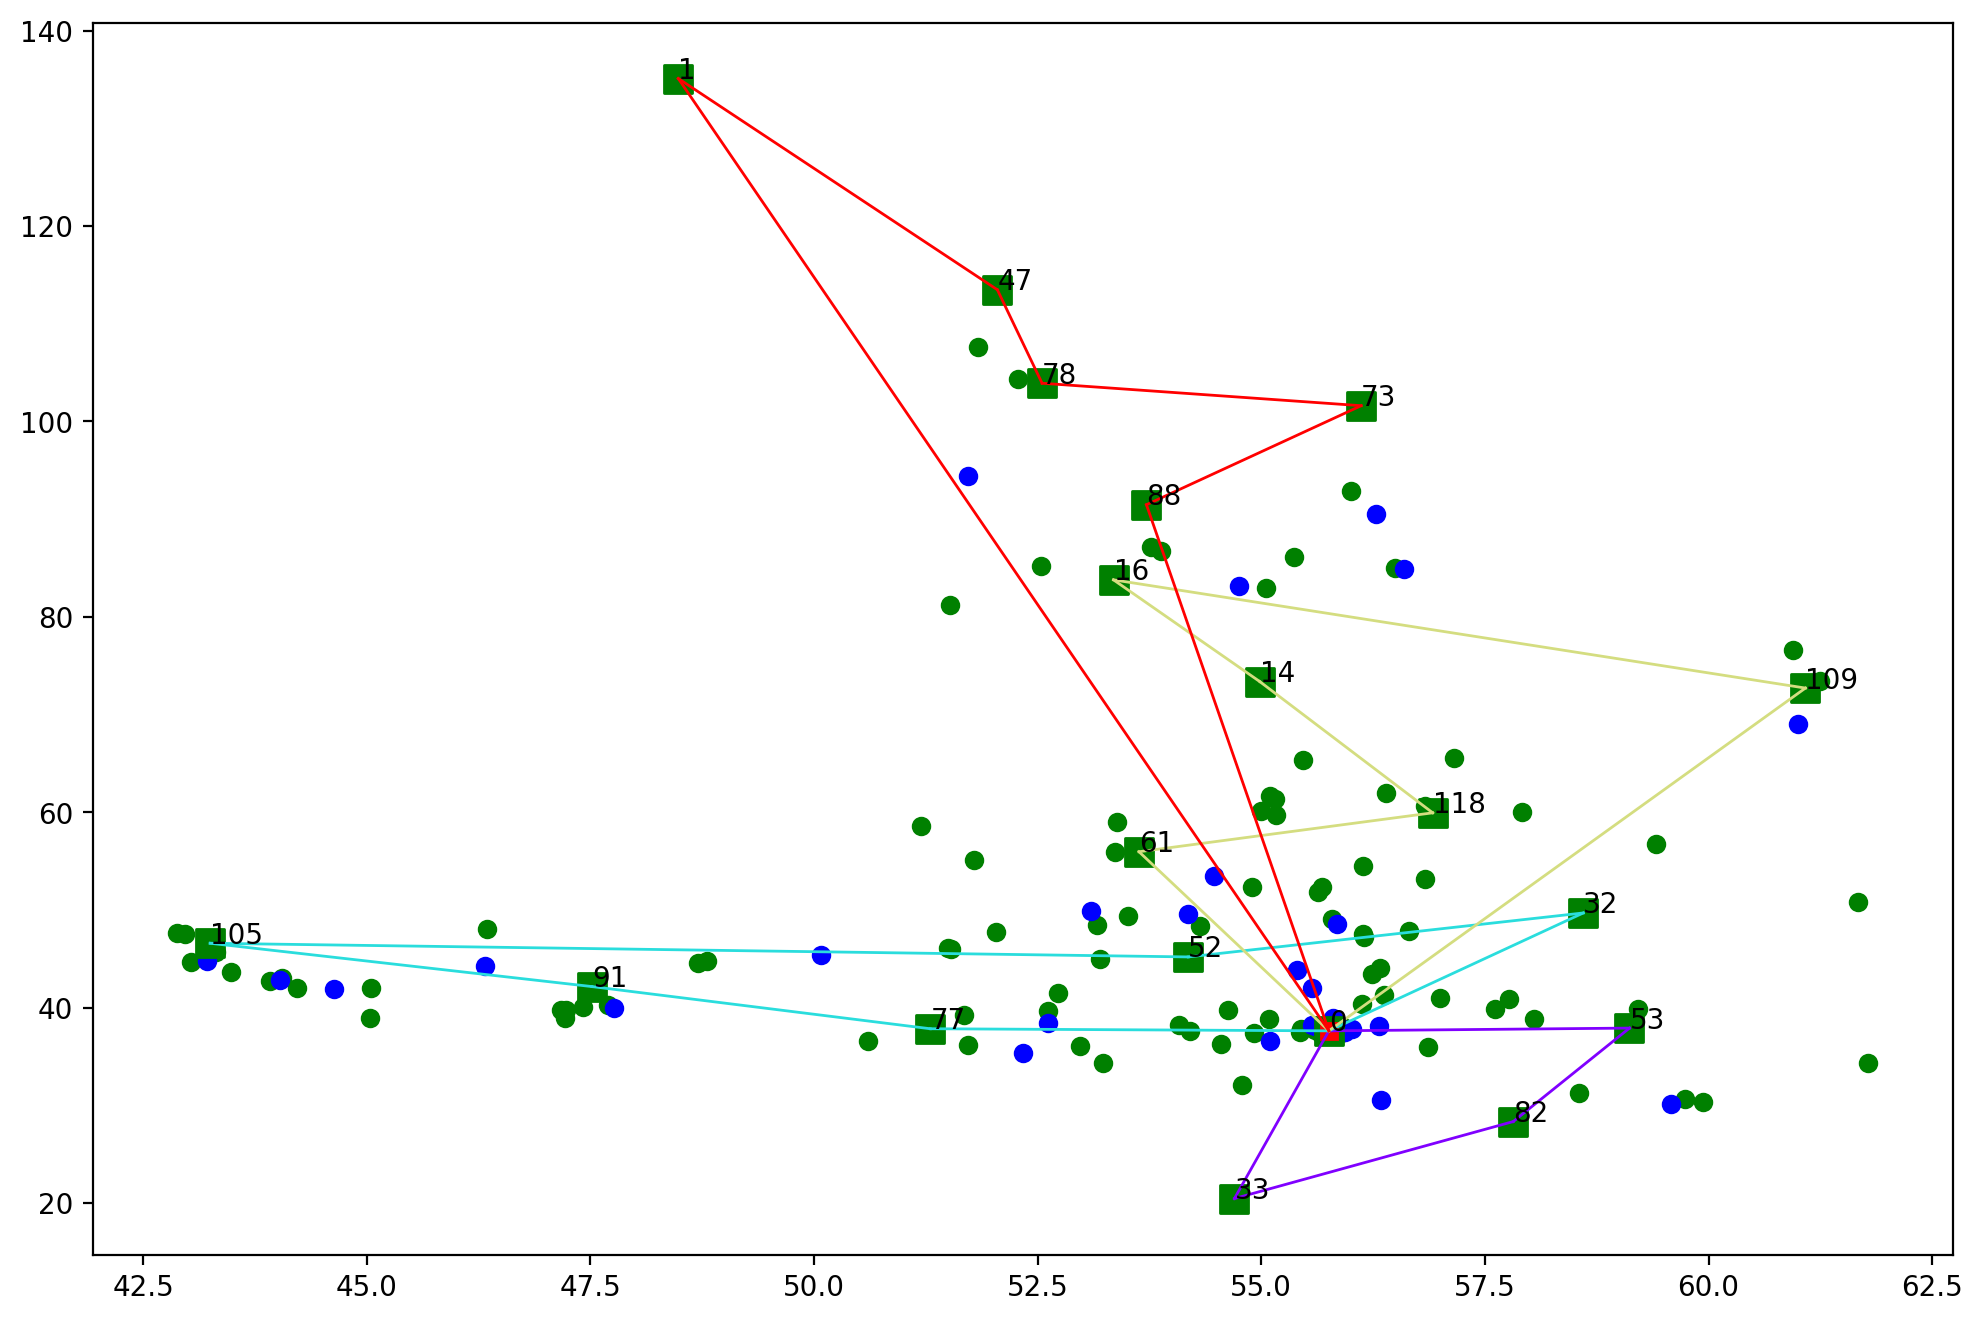

In [30]:
plot.get_figure()